# Proj2
> Write your own code to realize these functions:
> * Morphological edge detection
> * Morphological Reconstruction
>     * Conditional dilation in binary image
>     * Gray scale Reconstruction
>     * Morphological gradient
> 
> Requirements:
> * Design your own UI and display I/O images
> * User customized SE
> * Language：python or C++

Deadline: 2019/11/30

## Some notes:

* Dilation: $\oplus$
* Erosion: `$` or $\ominus$
* Opening: $A \circ B = (A \ominus B) \oplus B$
* Closing: $A \centerdot B = (A \oplus B) \ominus B$

(128, 128) uint8


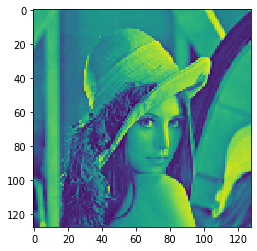

In [1]:
import cv2
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# process input

img_name = "lenna.png"
# img_name = "freak.png"
img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
# down scale to max 128 along the axis, preserving aspect ratio
m = max(img.shape[0], img.shape[1])
if m > 128:
    img = cv2.resize(img, (img.shape[1] * 128 // m, img.shape[0] * 128 // m))
print(img.shape, img.dtype)
plt.imshow(img)

124.0


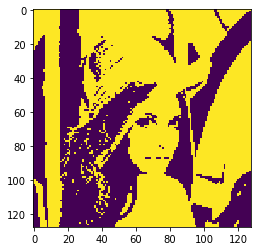

In [2]:
# produce binary image too
# we don't need to provide threshold here as OTSU method takes care of it
(thresh, im_bw) = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print(thresh)
plt.imshow(im_bw)

In [3]:
# morphological operations implementation
# default square kernel
binary_kernel = np.array([[1,1,1]] * 3)

def b_dilation(img_, kernel=binary_kernel):
    assert(kernel.shape[0] == kernel.shape[1])
    sz = kernel.shape[0]
    ew = sz // 2
    ret = np.zeros((img_.shape[0] + sz - 1, img_.shape[1] + sz - 1), 'uint8')
    for i in range(0, img_.shape[0]):
        for j in range(0, img_.shape[1]):
            if img_[i, j]:
                ret[i:i + sz, j:j + sz] = np.logical_or(ret[i:i + sz, j:j + sz], kernel)
    ret[ret > 0] = 255
    return ret[ew : -ew, ew: -ew]

def b_erosion(img_, kernel=binary_kernel):
    assert(kernel.shape[0] == kernel.shape[1])
    sz = kernel.shape[0]
    ew = sz // 2
    
    img = np.pad(img_, (ew, ew), 'edge')
    # square kernel
    nkern = np.logical_not(kernel)
    ret = np.zeros(img_.shape, 'uint8')
    for i in range(0, img_.shape[0]):
        for j in range(0, img_.shape[1]):
            # stands for P->Q(logical implication)
            ret[i, j] = np.logical_or(nkern, img[i:i + sz, j:j + sz]).all()
    
    ret[ret > 0] = 255
    return ret

def b_opening(img_, kernel=binary_kernel):
    return b_dilation(b_erosion(img_, binary_kernel), binary_kernel)

def b_closing(img_, kernel=binary_kernel):
    return b_erosion(b_dilation(img_, binary_kernel), binary_kernel)

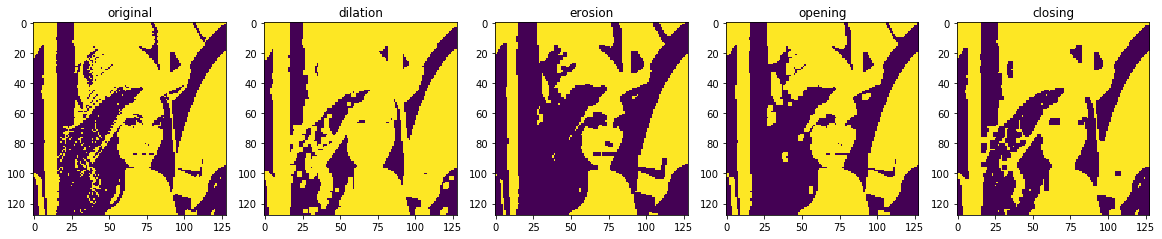

In [4]:
fig = plt.figure(figsize=(20,60))
fig.add_subplot(1,5,1)
plt.title("original")
plt.imshow(im_bw)
fig.add_subplot(1,5,2)
plt.title("dilation")
plt.imshow(b_dilation(im_bw))
fig.add_subplot(1,5,3)
plt.title("erosion")
plt.imshow(b_erosion(im_bw))
fig.add_subplot(1,5,4)
plt.title("opening")
plt.imshow(b_opening(im_bw))
fig.add_subplot(1,5,5)
plt.title("closing")
plt.imshow(b_closing(im_bw))

In [6]:
# edge detection
def edge_surrounding(img):
    return b_dilation(img) - b_erosion(img)

def edge_internal(img):
    return img - b_erosion(img)

def edge_external(img):
    return b_dilation(img) - img

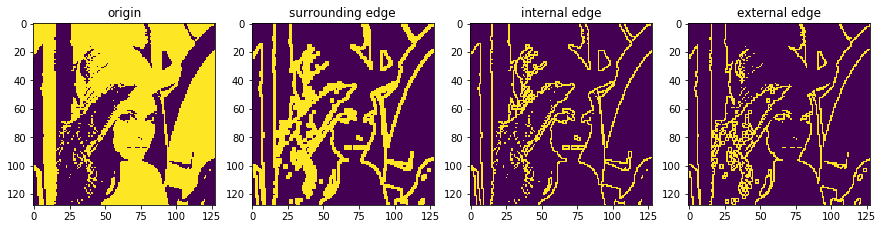

In [7]:
fig = plt.figure(figsize=(15,60))
fig.add_subplot(1,4,1)
plt.title("origin")
plt.imshow(im_bw)
fig.add_subplot(1,4,2)
plt.title("surrounding edge")
plt.imshow(edge_surrounding(im_bw))
fig.add_subplot(1,4,3)
plt.title("internal edge")
plt.imshow(edge_internal(im_bw))
fig.add_subplot(1,4,4)
plt.title("external edge")
plt.imshow(edge_external(im_bw))

In [8]:
# morphological reconstruction
def get_disc_kernel(ksize = 3):
    ret = np.ndarray((ksize, ksize))
    center = (ksize - 1) / 2
    disq = center ** 2
    
    for i in range(ksize):
        for j in range(ksize):
            ret[i,j] = (i - center) ** 2 + (j - center) ** 2 <= disq
    
    return ret

def get_marker(img_, ite_count = 20):
    from skimage.measure import label
    # generate marker image
    i = 0
    pimg = img_
    img = img_.copy()
    while np.any(img) and i < ite_count:
        pimg = img
        img = b_erosion(img)
        i = i + 1
    
    # mark the image
    return label(pimg)

In [9]:
def conditional_dilation(marker, mask, kernel=binary_kernel, max_itecnt = 50):
    assert(kernel.shape[0] == kernel.shape[1])
    sz = kernel.shape[0]
    ew = sz // 2
    ret = np.pad(marker, (ew, ew), 'constant', constant_values=(0,0))
    mask = np.pad(mask, (ew, ew), 'edge')
    mask[mask > 0] = 1
    pimg = None
    itecnt = 0
    while True:
        itecnt = itecnt + 1
        pimg = ret.copy()
        for i in range(0, marker.shape[0]):
            for j in range(0, marker.shape[1]):
                if pimg[i + ew, j + ew]:
                    ret[i:i + sz, j:j + sz] += (ret[i:i + sz, j:j + sz] == 0) * kernel * pimg[i + ew, j + ew]
        ret = mask * ret
        if np.all(pimg == ret) or itecnt > max_itecnt:
            break
        
    return ret

marker generated


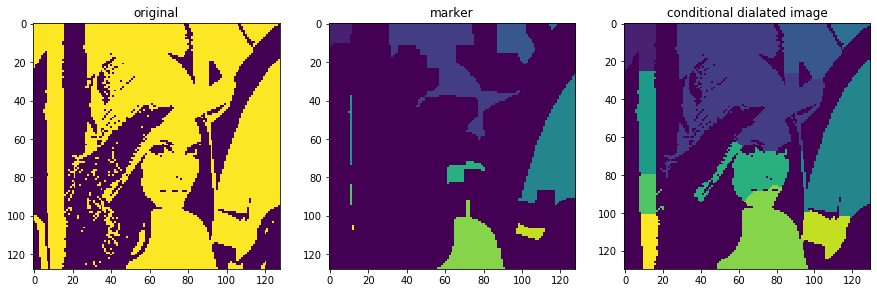

In [10]:
marker = get_marker(im_bw, 5)
print("marker generated")
gen = conditional_dilation(marker, im_bw)

fig = plt.figure(figsize=(15,45))
fig.add_subplot(1,3,1)
plt.title("original")
plt.imshow(im_bw)
fig.add_subplot(1,3,2)
plt.title("marker")
plt.imshow(marker)
fig.add_subplot(1,3,3)
plt.title("conditional dialated image")
plt.imshow(gen)

In [23]:
# grayscale reconstruction
# very similar with cd/gi
# default square kernel
gray_kernel = np.array([[-3,0,-3]] * 3)

def g_dilation(img_, kernel=binary_kernel):
    assert(kernel.shape[0] == kernel.shape[1])
    sz = kernel.shape[0]
    ew = sz // 2
    img = np.pad(img_, (ew, ew), 'edge').astype('int16')
    ret = np.ndarray(img_.shape, 'int16')
    for i in range(0, img_.shape[0]):
        for j in range(0, img_.shape[1]):
            ret[i, j] = np.max(img[i:i + sz, j:j + sz] + kernel)
    ret[ret > 255] = 255
    ret[ret < 0] = 0
    return ret.astype("uint8")

def g_erosion(img_, kernel=binary_kernel):
    assert(kernel.shape[0] == kernel.shape[1])
    sz = kernel.shape[0]
    ew = sz // 2
    img = np.pad(img_, (ew, ew), 'edge').astype('int16')
    ret = np.ndarray(img_.shape).astype('int16')
    for i in range(0, img_.shape[0]):
        for j in range(0, img_.shape[1]):
            ret[i, j] = np.min(img[i:i + sz, j:j + sz] - kernel)
    ret[ret > 255] = 255
    ret[ret < 0] = 0
    return ret.astype("uint8")

def g_opening(img_, kernel=binary_kernel):
    return g_dilation(g_erosion(img_, kernel), kernel)

def g_closing(img_, kernel=binary_kernel):
    return g_erosion(g_dilation(img_, kernel), kernel)

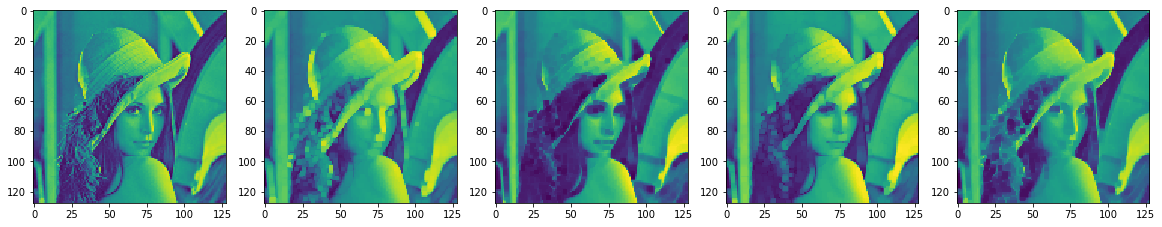

In [24]:
fig = plt.figure(figsize=(20, 60))
fig.add_subplot(1,5,1)
plt.imshow(img)
fig.add_subplot(1,5,2)
plt.imshow(g_dilation(img))
fig.add_subplot(1,5,3)
plt.imshow(g_erosion(img))
fig.add_subplot(1,5,4)
plt.imshow(g_opening(img))
fig.add_subplot(1,5,5)
plt.imshow(g_closing(img))


In [25]:
# morphological reconstruction
def get_disc_kernel(ksize = 3):
    ret = np.ndarray((ksize, ksize))
    center = (ksize - 1) / 2
    disq = center ** 2
    for i in range(ksize):
        for j in range(ksize):
            ret[i,j] = (i - center) ** 2 + (j - center) ** 2 <= disq
    return ret

def gray_reconstruct(img_, erosion_kernel=gray_kernel, dilation_kernel=gray_kernel, erosion_itecnt=10, dilation_itecnt=10):
    pimg = img_
    img = img_.copy()
    for i in range(erosion_itecnt):
        img = g_erosion(img, erosion_kernel)
    # reconstruct the image
    for i in range(dilation_itecnt):
        img = np.minimum(img_, g_dilation(img, dilation_kernel))
    return img

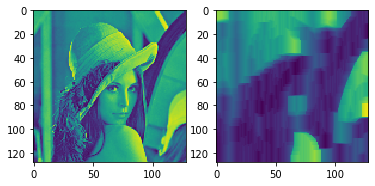

In [26]:
limg = gray_reconstruct(img, erosion_itecnt=10, dilation_itecnt=5)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(limg)

In [32]:
# morphological gradient
def gradient_external(img):
    return 0.5 * (g_dilation(img) - img)

def gradient_internal(img):
    return 0.5 * (img - g_erosion(img))

def gradient_surrounding(img):
    return 0.5 * (g_dilation(img) - g_erosion(img))

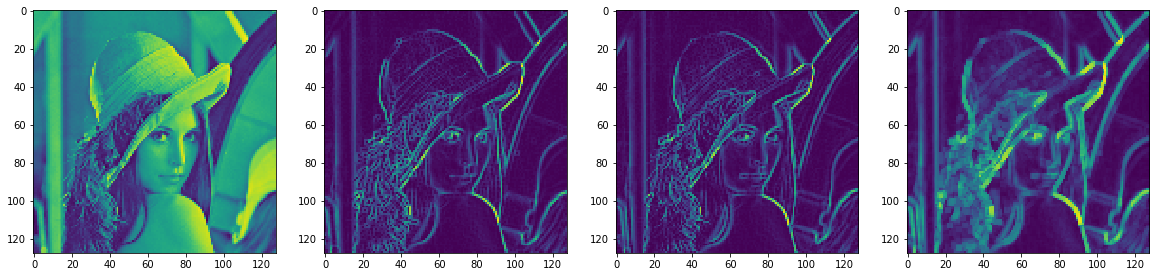

In [33]:
fig = plt.figure(figsize=(20,60))
fig.add_subplot(1,4,1)
plt.imshow(img)
fig.add_subplot(1,4,2)
plt.imshow(gradient_external(img))
fig.add_subplot(1,4,3)
plt.imshow(gradient_internal(img))
fig.add_subplot(1,4,4)
plt.imshow(gradient_surrounding(img))